In [155]:
import os 
import pickle
import pandas as pd
import numpy as np
from importlib import reload

import feature_selection
import sampling

reload(feature_selection)
reload(sampling)

from feature_selection import select_common_features
from sampling import create_stratified_kfolds, create_stratified_train_test_sets


from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, \
    matthews_corrcoef, mean_squared_error, r2_score, roc_auc_score, roc_curve, auc
from math import sqrt
from sklearn.model_selection import GridSearchCV

from summarytools import dfSummary
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [156]:
# TEMPORARY
import warnings
warnings.filterwarnings("ignore")

### Notebook parameters

In [157]:
# notebook parameters
input_dataset_path = "data/heart_disease_health_indicators_BRFSS2015.csv"
target_col = "HeartDiseaseorAttack"
separator = ','

generate_new_folds = False
n_splits = 10

In [158]:
fix_imbalanced_dataset = False
use_oversampling = False
use_undersampling = False

In [159]:
models_saving_directory = 'models/ratio_2_1_random'

### Functions

In [160]:
def calculate_metrics(y_pred: np.array, y_test: pd.Series):
    """ Calculate model quality metrics based on 
        expected label values from testing dataset (y_test) and predicted values.
    """
    tn, fp, fn, tp = calculate_test_results_from_confusion_matrix(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred) # sensitivity
    model_specificity = specificity_score(tn, fp)
    model_acc = accuracy_score(y_test, y_pred)
    model_npv = calculate_npv(tn, fn)

    model_f1_score = f1_score(y_test, y_pred)
    model_mcc = matthews_corrcoef(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    model_r2 = r2_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    model_scores = {
        "True_Negative": tn,
        "False_Positive": fp,
        "False_Negative": fn,
        "True_Positive": tp,
        "Precision_PPV": model_precision,
        "Sensitivity_TPR_Recall": model_recall,
        "Speciticity_TNR": model_specificity,
        "Accuracy": model_acc,
        "Negative_Predictive_Value_NPV": model_npv,
        "F1_Score": model_f1_score,
        "RMSE": rmse,
        "R_Squared": model_r2,
        "Matthews_Correlation_Coefficient_MCC": model_mcc,
        # "Threshold_from_ROC_Curve": list(thresholds),
        # "False_Positive_Rate_FPR": list(fpr),
        "ROC_AUC_score": roc_auc
    }

    model_scores_df = pd.DataFrame(model_scores.values(), index=model_scores.keys()).transpose()

    return model_scores_df

def calculate_test_results_from_confusion_matrix(y_test: pd.DataFrame, y_pred: pd.DataFrame):
    """ Calculate the confusion matrix and extract TP, FP, TN, FN from that matrix """
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    return tn, fp, fn, tp

def specificity_score(tn: float, fp: float):
    return tn / (tn + fp)

def calculate_npv(tn: float, fn: float):
    return tn / (tn + fn)

### 1. Load data

In [199]:
heart_df = pd.read_csv(input_dataset_path, sep=separator)
heart_df.drop(columns=[col for col in heart_df.columns if col.lower()=='id'], inplace=True)
if all(isinstance(item, (int, float, np.int32, np.int64)) for item in list(heart_df[target_col].unique())):
    heart_df[target_col] = heart_df[target_col].astype(int)
heart_df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


#### 1.1 Check basic descriptors of the dataset

In [200]:
assert heart_df[heart_df.isna().any(axis=1)].empty, 'Dataset contains NaN values!'

In [201]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=[target_col]).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df[target_col].unique()}")
print(f"Number of classes in target: {heart_df[target_col].unique().shape[0]}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 253680 rows and 22 colums
Input dataset consists of 21 features and 1 target column
Target values are: [0 1]
Number of classes in target: 2
Input dataset contains 23899 duplicated rows and 229781 unique rows


### 2. Exploratory Data Analysis

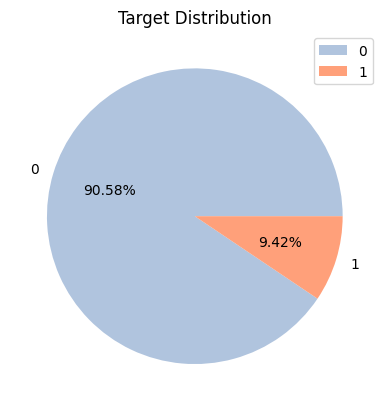

In [202]:
plt.pie(x=heart_df[target_col].value_counts().values,labels=heart_df[target_col].unique().tolist(),autopct='%1.2f%%', colors=['lightsteelblue', 'lightsalmon'])
plt.title('Target Distribution')
plt.legend()
plt.show()

<Axes: >

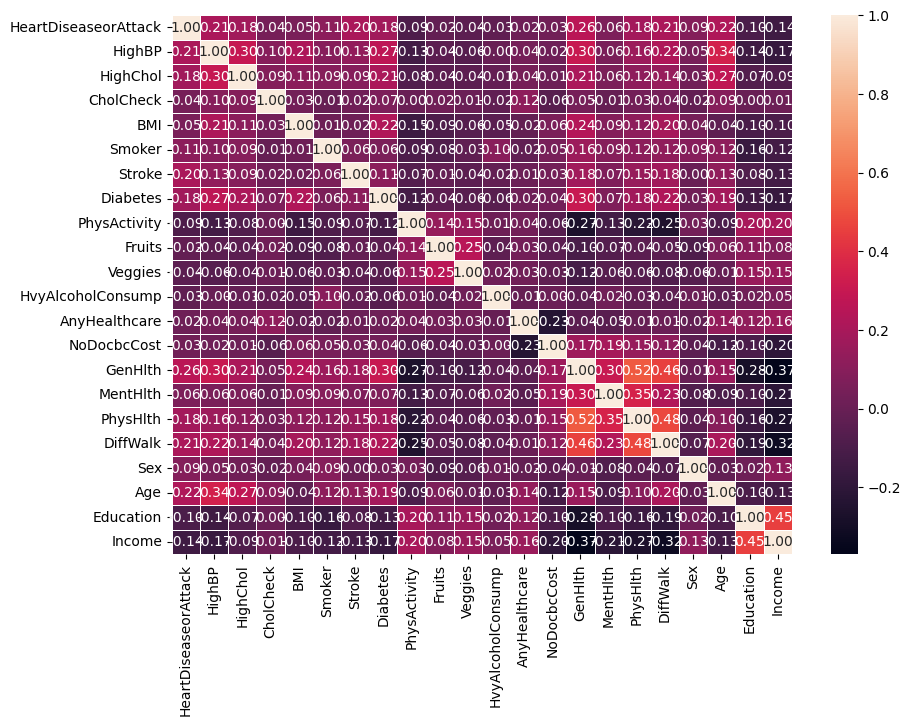

In [165]:
corr_matrix = heart_df.corr()
f,ax=plt.subplots(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5, ax=ax)

In [166]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  int64  
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [167]:
dfSummary(heart_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,HeartDiseaseorAttack[int64],1. 02. 1,"229,787 (90.6%)23,893 (9.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bQWrDMBRF0a9iQjKRMAYvxovIYrsI7cYYa9CETNRB5yGW3JfWumdu+IOLIcHP5ZwNUHBmdjGz07sPwb/xyDnfSh7shmG4eu/7vS/CMaWUFufcZ0lwnfe+n6bpFkK4/8ZxOI51Xc8xxn6e55OZbY/NzCyEcB/H8Wv363BEl9IHP/a8AniG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmc7s56O4dx+Cv6+2ky6ltMQYe6v4KA7tSCktZvYoeZbBC7YqHrw4pnxQqX2zFVeO9lRN+WpmXWhP8ZSvdtaF9tRO+fgFi5fxpy5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCme8jH/w1ZVU76aWRfaw+AFMt8KW2rfOfaTaQAAAABJRU5ErkJggg=="">",0(0.0%)
2,HighBP[float64],1. 0.02. 1.0,"144,851 (57.1%)108,829 (42.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABM0lEQVR4nO3bQWrDMBhE4VExodlIGIMP40P0sD2EbmOMtWhCNuqiAZ9Ao2K/7wR/wsOQ4Am1VgEOQdJd0q33ISf3qrU+eh/R2zBN01eMcex9yJmVUrYQwvfVgxtijOOyLI+U0rP3MWe07/tnznlc1/Um6dqxSVJK6TnP80/vY07s3vuA/+Cj9wG4DmKDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2wG6e8Fv96HnBXf7WEopWw551G84NdMKWWT9Op9R28MXjwYvEgKTPngwpPtwNOnMaZ8b8zt2mPKJ+Z2Lkz5Dvwab4w/dWFDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDVM+8fldmPK9Mbdrj8HLgcFLY78KW2rfLYfn7QAAAABJRU5ErkJggg=="">",0(0.0%)
3,HighChol[float64],1. 0.02. 1.0,"146,089 (57.6%)107,591 (42.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABM0lEQVR4nO3bQWrDMBhE4VExodlIGIMP40P0sD2EbmOMtWhCNuqiAZ9Ao2K/7wR/wsOQ4Am1VgEOQdJd0q33ISf3qrU+eh/R2zBN01eMcex9yJmVUrYQwvfVgxtijOOyLI+U0rP3MWe07/tnznlc1/Um6dqxSVJK6TnP80/vY07s3vuA/+Cj9wG4DmKDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2wG6e8Fv96HnBXf7WEopWw551G84NdMKWWT9Op9R28MXjwYvEgKTPngwpPtwNOnMaZ8b8zt2mPKJ+Z2Lkz5Dvwab4w/dWFDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDVM+8fldmPK9Mbdrj8HLgcFLY78KW2rfLYfn7QAAAABJRU5ErkJggg=="">",0(0.0%)
4,CholCheck[float64],1. 1.02. 0.0,"244,210 (96.3%)9,470 (3.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bMWrDMBiG4V/FhGaRMAYfxofoYXsI3cYYa2hCFnXoVGMZYppPoL7P6OkfXgwJ/lzO2QAFZ2ZXM7vUPgRNeeScb9uH3TAMH977vsZFaFNKaXHOfW6D67z3/TRNtxDCvdZxaMe6ru8xxn6e54uZ/Y7NzCyEcB/H8avKdWjRde/hm/oK/F/EBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIdGY/H7zVPgRtOGqpSyktMcbeCh+8Ac9KKS1m9tg+Z/CCV9gdvDimfFA5erPt1gmcVZzyleZYwFm7U76jORZw1tGUj1+n+FP8qQsZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZHanfEz78ArFKV9pjgWcxeAFMt8KW2rfzqzdbgAAAABJRU5ErkJggg=="">",0(0.0%)
5,BMI[float64],Mean (sd) : 28.4 (6.6)min < med < max:12.0 < 27.0 < 98.0IQR (CV) : 7.0 (4.3),84 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACVklEQVR4nO3dMY7aQBiG4X/CggwoY1mWoOMCkVJQ+hB72LTpUnACbkCDkBAY4cXBGKdKmSy2IfHHvk8/sxa88mKkn3FVVRnQdZ/+9wUAt3h55ObOuaGZDVpsca6q6nSv64Guh4XqnBvGcfzqvY+a7nE4HHbOuW/EikfeUQfe+yhJklMYhnndxWmaBovFItputwMzI9QP7qH/+s3MwjDMJ5PJW8Plw7teDGTxMAUJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJD//F6TbKsuybmXfONVnOQRVPpLOhZlnWL4ri62w26/V6vdpnAHBQxXPpbKjn8/klCILRfD7Pp9Pprs5aDqp4Pp0N9bfxeNz0sAoOqngiPExBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCQudnpppqOWptxrh1p7wbqnNuaGaDBnv76/Xab7Cutbaj1maMW3fNX0N1zg3jOH713kd1Ny6KIijL8kue5z/MrMkUaWNtRq3NGLfuovfuqAPvfZQkySkMw1p3ptVqFS2Xy9Hlcum1uL5WWoxamzFu3Sk3fUYNw7D2G77b7XijcT

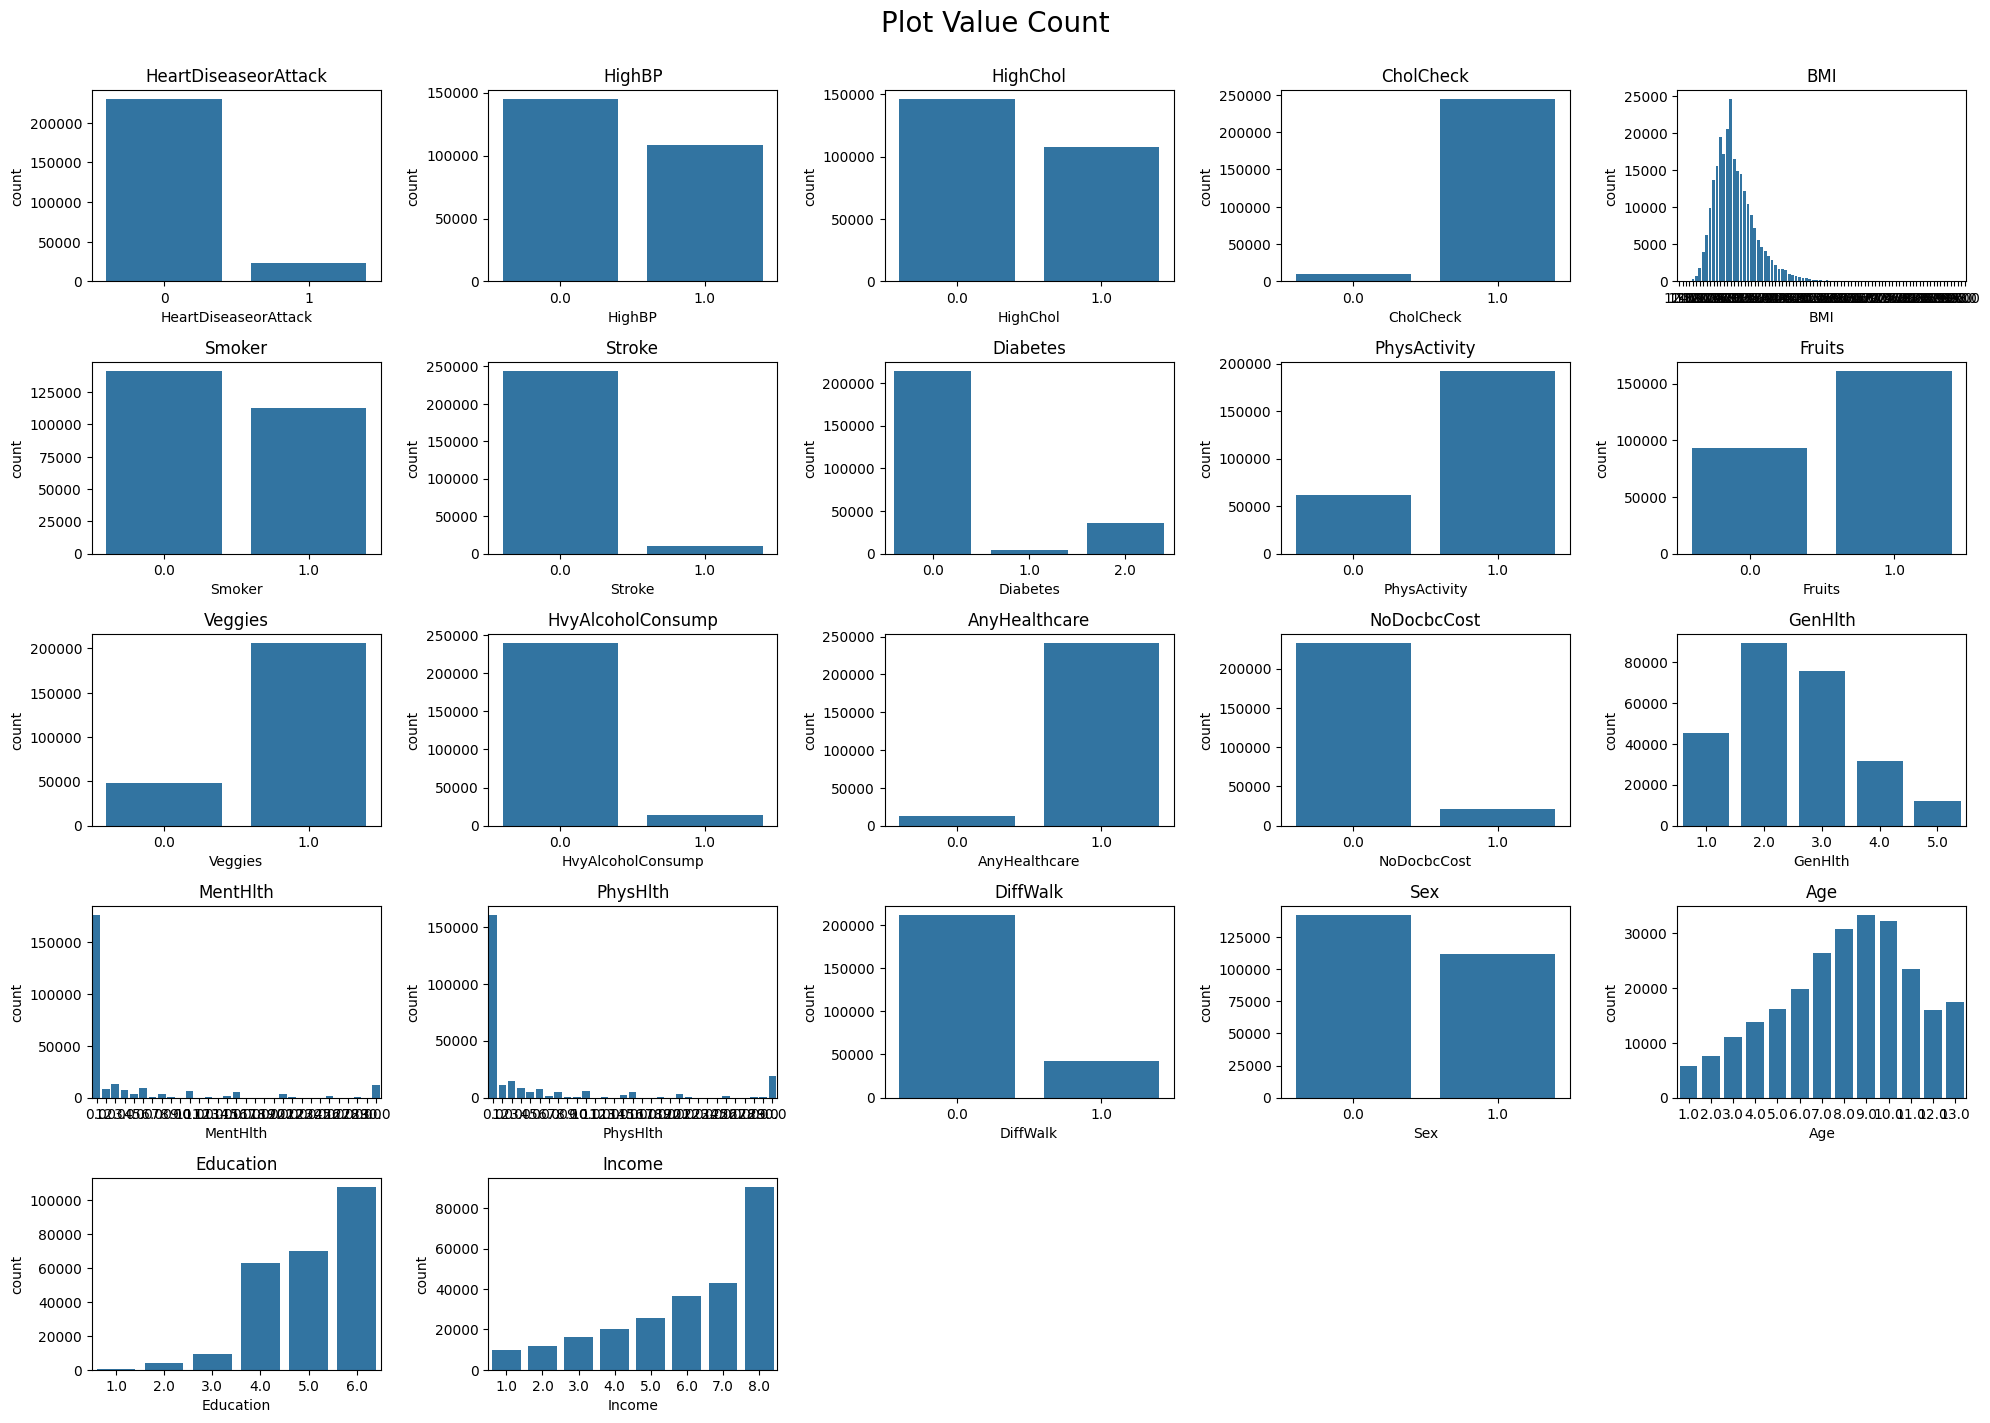

In [168]:
# Countplot on each feature
plt.figure(figsize=(20,60))
for i,column in enumerate(heart_df.columns):
    plt.subplot(len(heart_df.columns), 5, i+1)
    plt.suptitle("Plot Value Count", fontsize=20, x=0.5, y=1)
    sns.countplot(data=heart_df, x=column)
    plt.title(f"{column}")
    plt.tight_layout()

In [169]:
bin_features = ['HighBP', 'HighChol', 'CholCheck','Smoker', 'Stroke','PhysActivity', 'Fruits', 'Veggies', 
                'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
cat_features = ['Diabetes', 'GenHlth', 'Education','Income']
num_features = ['BMI','MentHlth', 'PhysHlth', 'Age']

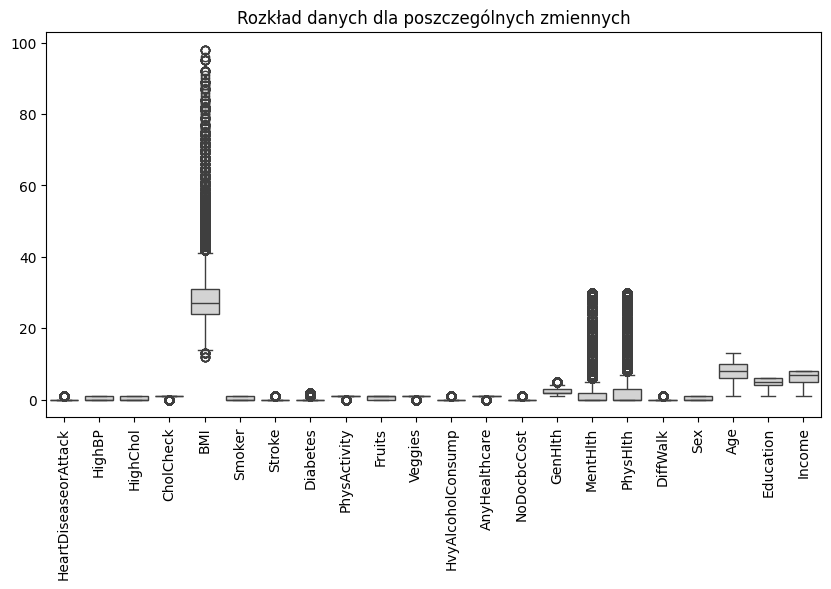

In [170]:
plt.figure(figsize=(10,5))
sns.boxplot(heart_df, color='lightgray')
l=list(np.arange(22))
plt.title("Rozkład danych dla poszczególnych zmiennych")
plt.xticks(l, list(heart_df.columns),
       rotation=90)
plt.show()

### 3. Data preprocessing

#### 3.1 Drop duplicated observations

In [171]:
# delete all duplicated values within the dataset
heart_df.drop_duplicates(inplace=True)

#### 3.2 Encode non-numerical features

In [172]:
label_encoders = {}

# Iterate through columns with categorical data
for column in heart_df.columns:
    if heart_df[column].dtype == 'object':
        le = LabelEncoder()
        heart_df[column] = le.fit_transform(heart_df[column])
        label_encoders[column] = le
        print(f'{column} was encoded')

#### 3.3 Separate features from labels

In [173]:
# divide a heart failure dataset into features and target value sets
X = heart_df.drop(columns=[target_col])
y = heart_df[target_col]

### 4. Data sampling

In [174]:
# if generate_new_folds:
#     X_train, X_test, y_train, y_test = create_stratified_train_test_sets(x_df=X, 
#                                                                         y_df=y, 
#                                                                         test_size=0.2)
# else:
#     X_train = pd.read_csv('split_data/X_train_total.csv')
#     X_test = pd.read_csv('split_data/X_test_total.csv')
#     y_train = pd.read_csv('split_data/y_train_total.csv')
#     y_test = pd.read_csv('split_data/y_test_total.csv')
#     print('Data was loaded successfully')

#### 4.1 Generate K-folds or read them from files

In [175]:
# if needed generare and save into CSV files new folds created by stratified data sampling
if generate_new_folds:
    create_stratified_kfolds(x_df=X, y_df=y, dataset=heart_df, n_splits=n_splits)

# Read folds that are available
# Create empty lists to store train and test DataFrames
train_datasets = []
test_datasets = []

for fold_num in range(1, n_splits+1):
    train_file_path = f"folds/fold_{fold_num}_train.csv"
    test_file_path = f"folds/fold_{fold_num}_test.csv"
    
    # Load the train and test fold data into DataFrames
    train_fold = pd.read_csv(train_file_path)
    test_fold = pd.read_csv(test_file_path)
    
    train_datasets.append(train_fold)
    test_datasets.append(test_fold)
print("Folds data were loaded successfully!")

Folds data were loaded successfully!


### 5. Feature selection across folds

In [176]:
selected_features_across_folds = []
for fold_num, (train_data, test_data) in enumerate(zip(train_datasets, test_datasets),1):

    fX_train = train_data.drop(columns=[target_col])
    fy_train = train_data[target_col]

    common_features_for_fold = select_common_features(X_train=fX_train, y_train=fy_train, fold_num=fold_num)
    selected_features_across_folds.append(common_features_for_fold)

In [177]:
sets = [set(t) for t in selected_features_across_folds]
common_elements = list(set.intersection(*sets))
print(f'Across all methods within all folds there were {len(common_elements)} selected.\nThese are: {common_elements}')

Across all methods within all folds there were 9 selected.
These are: ['HighChol', 'Diabetes', 'Age', 'HighBP', 'Income', 'Education', 'GenHlth', 'PhysHlth', 'Sex']


#### 5.1 Verify correlation of features with target

In [178]:
corr_with_target = pd.DataFrame(heart_df.corr()[target_col]).rename(columns={target_col: 'corr'})
corr_with_target['corr'] = abs(corr_with_target['corr'])
corr_with_target.sort_values(by='corr', inplace=True, ascending=False)
corr_with_target.drop(target_col, inplace=True)

<Axes: >

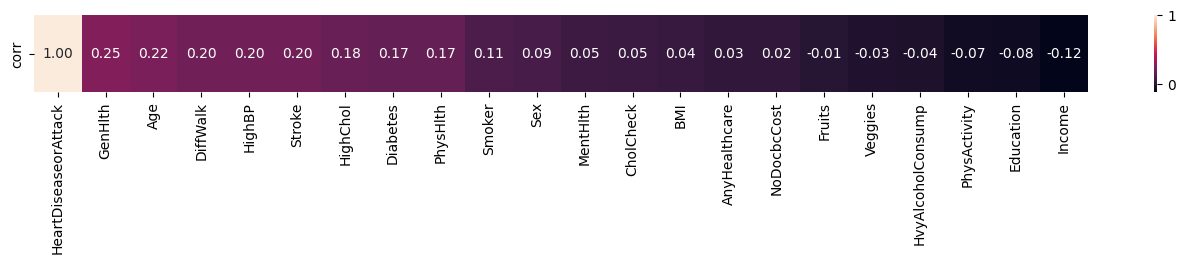

In [179]:
corr_target = pd.DataFrame(heart_df.corr()[target_col]).rename(columns={target_col: 'corr'})
corr_target.sort_values(by='corr', inplace=True, ascending=False)
plt.figure(figsize=(17, 1))
sns.heatmap(corr_target.transpose(), fmt=".2f", annot=True)

In [180]:
correlated_f = list(corr_with_target[0:len(common_elements)].index)
best_features = list(set(correlated_f).intersection(common_elements))
print(f'Across all methods including check of target correlation within all folds there were {len(best_features)} selected.\nThese are: {best_features}')

Across all methods including check of target correlation within all folds there were 7 selected.
These are: ['HighChol', 'Diabetes', 'Age', 'HighBP', 'Income', 'GenHlth', 'PhysHlth']


### 6. Modeling

#### 6.1 Model definitions

In [181]:
clf1 = LogisticRegression(multi_class='multinomial',
                          solver='newton-cg',
                          random_state=1)
clf2 = KNeighborsClassifier(algorithm='ball_tree',
                            leaf_size=50)
clf3 = DecisionTreeClassifier(criterion='gini', random_state=1)
clf4 = SVC(kernel="linear", C=0.3, random_state=1)
clf5 = RandomForestClassifier(random_state=1)
clf6 = XGBClassifier(objective= 'binary:logistic',
                    nthread=4,
                    seed=42)
clf7 = GaussianNB()

In [182]:
if fix_imbalanced_dataset and use_oversampling:
    # sampler = SMOTE(random_state=42)
    sampler = RandomOverSampler(random_state=42)
elif fix_imbalanced_dataset and use_undersampling:
    sampler = RandomUnderSampler(random_state=42)

#### 6.3 Define pipelines

In [183]:
if fix_imbalanced_dataset:
    pipe1 = Pipeline_imb([('sampler', sampler),
                          ('scaler', StandardScaler()),
                          ('LR', clf1)])

    pipe2 = Pipeline_imb([('sampler', sampler),
                          ('scaler', StandardScaler()),
                          ('KNN', clf2)])
    
    pipe3 = Pipeline_imb([('sampler', sampler),
                          ('DT', clf3)])

    pipe4 = Pipeline_imb([('sampler', sampler),
                          ('scaler', StandardScaler()),
                          ('SVM', clf4)])
    
    pipe5 = Pipeline_imb([('sampler', sampler),
                          ('RF', clf5)])

    pipe6 = Pipeline_imb([('sampler', sampler),
                          ('XGB', clf6)])

    pipe7 = Pipeline_imb([('sampler', sampler),
                          ('scaler', StandardScaler()),
                          ('GNB', clf7)])

else:
    # Building the pipelines based on pre defined classifiers
    pipe1 = Pipeline([('scaler', StandardScaler()),
                    ('LR', clf1)])

    pipe2 = Pipeline([('scaler', StandardScaler()),
                    ('KNN', clf2)])
    
    pipe3 = Pipeline([('DT', clf3)])

    pipe4 = Pipeline([('scaler', StandardScaler()),
                    ('SVM', clf4)])
    
    pipe5 = Pipeline([('RF', clf5)])

    pipe6 = Pipeline([('XGB', clf6)])

    pipe7 = Pipeline([('scaler', StandardScaler()),
                    ('GNB', clf7)])

#### 6.4 Set up parameter grids for GridSearchCV hyperparameter tuning

In [184]:
# # Logistic Regression parameters
# param_grid1 = [{'LR__penalty': ['l1', 'l2'],
#                 'LR__C': np.power(10., np.arange(-4, 4))}]

# # KNN parameters
# param_grid2 = [{'KNN__n_neighbors': list(range(1, 10)),
#                 'KNN__p': [1, 2]}]

# # Decision Trees parametersTrue
# param_grid3 = [{'DT__max_depth': list(range(1, 10)) + [None],
#                 'DT__criterion': ['gini', 'entropy']}]

# # SVM parameters
# param_grid4 = [{'SVM__kernel': ['rbf'],
#                 'SVM__C': np.power(10., np.arange(-4, 4)),
#                 'SVM__gamma': np.power(10., np.arange(-5, 0))},
#                {'SVM__kernel': ['linear'],
#                 'SVM__C': np.power(10., np.arange(-4, 4))}]

# # Random Forest parameters
# param_grid5 = [{'RF__n_estimators': [10, 100, 500, 1000, 10000]}]

# # XGBoost parameters
# param_grid6 = [{'XGB__max_depth': range (2, 10, 1),
#                'XGB__n_estimators': range(60, 220, 40),
#                'XGB__learning_rate': [0.1, 0.01, 0.05]}]

# # Gausian Naive Bayes parameters
# param_grid7 = [{'GNB__var_smoothing': np.logspace(0,-9, num=100)}]

In [185]:
# gridcvs = {}
# for pgrid, est, name in zip((param_grid1, param_grid3, param_grid5, param_grid6, param_grid7),
#                            (pipe1, pipe3, pipe5, pipe6, pipe7),
#                            ('LR', 'DT', 'RF', 'XGB', 'GNB')):
#    gcv = GridSearchCV(estimator=est,
#                      param_grid=pgrid,
#                      scoring='f1',
#                      cv=10,
#                      n_jobs=-1,
#                      verbose=0,
#                      refit=True)
#    gridcvs[name] = gcv

In [186]:
model_results_df_lst = []

for fold_num, (train_data, test_data) in enumerate(zip(train_datasets, test_datasets),1):

    # ########## Take 2:1 ratio of negative to positive class #########################

    positive_class_df = train_data[train_data[target_col]==1]
    negative_class_df = train_data[train_data[target_col]==0]

    positive_class_samples_count = len(positive_class_df)
    negative_class_samples_count = 2*positive_class_samples_count

    randomly_selected_negative_class_samples = negative_class_df.sample(n=negative_class_samples_count, random_state=42)
    
    preselected_train_data = pd.concat([positive_class_df, randomly_selected_negative_class_samples], axis=0)
    preselected_train_data = preselected_train_data.sample(frac=1.0, ignore_index=True)

    # ################################################################################

    fX_train = preselected_train_data.drop(columns=[target_col])[best_features]
    fy_train = preselected_train_data[target_col]

    fX_test = test_data.drop(columns=[target_col])[best_features]
    fy_test = test_data[target_col]

    fold_results = []

    for est, name in zip((pipe1, pipe3, pipe5, pipe6, pipe7, pipe4, pipe2), ('LR', 'DT', 'RF', 'XGB', 'GNB', 'SVM', 'KNN')):
        est.fit(X=fX_train, y=fy_train)
        fy_pred = est.predict(X=fX_test)

        # Create a directory if it doesn't exist
        if not os.path.exists(f'{models_saving_directory}/{name}'):
            os.makedirs(f'{models_saving_directory}/{name}')

        with open(f'{models_saving_directory}/{name}/{name}_model_fold_no{fold_num}.pickle', 'wb') as file:
            pickle.dump(est.named_steps[name], file)

        est_scores_df = calculate_metrics(y_test=fy_test, y_pred=fy_pred)
        est_scores_df['model_name'] = name
        est_scores_df.to_excel(f'{models_saving_directory}/{name}/{name}_model_result_fold_no{fold_num}.xlsx')
        print(f'Log: {name} finished')

        fold_results.append(est_scores_df)

    fold_results_df = pd.concat(fold_results, ignore_index=True)
    fold_results_df['fold no'] = fold_num

    model_results_df_lst.append(fold_results_df)
    
    print(f'Fold no: {fold_num} finished')
    print(50 * '-', '\n')

fs_model_results_df = pd.concat(model_results_df_lst, ignore_index=True)

Log: LR finished
Log: DT finished
Log: RF finished
Log: XGB finished
Log: GNB finished
Log: SVM finished
Log: KNN finished
Fold no: 1 finished
-------------------------------------------------- 

Log: LR finished
Log: DT finished
Log: RF finished
Log: XGB finished
Log: GNB finished
Log: SVM finished
Log: KNN finished
Fold no: 2 finished
-------------------------------------------------- 

Log: LR finished
Log: DT finished
Log: RF finished
Log: XGB finished
Log: GNB finished
Log: SVM finished
Log: KNN finished
Fold no: 3 finished
-------------------------------------------------- 

Log: LR finished
Log: DT finished
Log: RF finished
Log: XGB finished
Log: GNB finished
Log: SVM finished
Log: KNN finished
Fold no: 4 finished
-------------------------------------------------- 

Log: LR finished
Log: DT finished
Log: RF finished
Log: XGB finished
Log: GNB finished
Log: SVM finished
Log: KNN finished
Fold no: 5 finished
-------------------------------------------------- 

Log: LR finished
Log

In [187]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
fs_model_results_df.to_excel(f'{models_saving_directory}/models_results_{timestamp}.xlsx', header=True)

In [188]:
with open(f'{models_saving_directory}/used_features_{timestamp}.txt', "w") as file:
    for item in fX_train.columns:
        file.write(str(item) + "\n")

In [189]:
fs_model_results_df

,True_Negative,False_Positive,False_Negative,True_Positive,Precision_PPV,Sensitivity_TPR_Recall,Speciticity_TNR,Accuracy,Negative_Predictive_Value_NPV,F1_Score,RMSE,R_Squared,Matthews_Correlation_Coefficient_MCC,ROC_AUC_score,model_name,fold no
0,17629.0,2978.0,1092.0,1280.0,0.300611,0.539629,0.855486,0.822882,0.941670,0.386124,0.420854,-0.913357,0.309400,0.697558,LR,1
1,17141.0,3466.0,1213.0,1159.0,0.250595,0.488617,0.831805,0.796379,0.933911,0.331285,0.451244,-1.199656,0.243145,0.660211,DT,1
2,16963.0,3644.0,1102.0,1270.0,0.258445,0.535413,0.823167,0.793464,0.938998,0.348614,0.454463,-1.231153,0.266081,0.679290,RF,1
3,17186.0,3421.0,1023.0,1349.0,0.282809,0.568718,0.833988,0.806606,0.943819,0.377765,0.439766,-1.089179,0.302101,0.701353,XGB,1
4,16296.0,4311.0,919.0,1453.0,0.252082,0.612563,0.790799,0.772401,0.946616,0.357178,0.477073,-1.458688,0.283103,0.701681,GNB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,16960.0,3646.0,1109.0,1263.0,0.257283,0.532462,0.823061,0.793063,0.938624,0.346930,0.454903,-1.235395,0.263912,0.677762,RF,10
66,17301.0,3305.0,1053.0,1319.0,0.285251,0.556071,0.839610,0.810340,0.942628,0.377073,0.435499,-1.048760,0.300279,0.697840,XGB,10
67,16369.0,4237.0,968.0,1404.0,0.248892,0.591906,0.794380,0.773479,0.944166,0.350431,0.475942,-1.446947,0.273085,0.693143,GNB,10
68,17569.0,3037.0,1119.0,1253.0,0.292075,0.528246,0.852616,0.819131,0.940122,0.376163,0.425287,-0.953797,0.297380,0.690431,SVM,10


In [192]:
# svc_clf = SVC(gamma='scale', class_weight='balanced')
# svc_pipe = Pipeline([('scaler', StandardScaler()),
#                       ('SVM', svc_clf)])

# svc_param_grid = [{'SVM__kernel': ['rbf'],
#                 'SVM__C': np.power(10., np.arange(-4, 4)),
#                 'SVM__gamma': np.power(10., np.arange(-5, 0))},
#                {'SVM__kernel': ['linear'],
#                 'SVM__C': np.power(10., np.arange(-4, 4))}]

# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# svc_model_select = GridSearchCV(estimator=svc_pipe,
#                                 param_grid=svc_param_grid,
#                                 scoring='roc_auc',
#                                 n_jobs=-1,
#                                 verbose=1,
#                                 refit=True)

# svc_model_select.fit(X_train[best_features], y_train)
# print('Best CV ROC AUC score: %.4f' % (svc_model_select.best_score_))
# print('Best parameters:', svc_model_select.best_params_)

# import pickle
# import datetime
# import openpyxl

# timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# with open(f'models/svc_imbalanced_{timestamp}.pickle', 'wb') as file:
#     pickle.dump(svc_model_select, file)

# y_pred = svc_model_select.predict(x=X_test[best_features])
# svc_scores_df = calculate_metrics(y_test=y_test, y_pred=y_pred)
# svc_scores_df.to_excel(f'models/svc_imbalanced_{timestamp}.xlsx', index=False, header=True)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/aid/anaconda3/envs/magisterka/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aid/anaconda3/envs/magisterka/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aid/anaconda3/envs/magisterka/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aid/anaconda3/envs/magisterka/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vecto

KeyboardInterrupt: 